In [1]:
!pip install wfdb
!pip install hrv-analysis
!pip install py-ecg-detectors
!pip install neurokit2

from google.colab import output
output.clear()
print("Packages installed successfully")

Packages installed successfully


In [2]:
import pprint
import os
import datetime

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import wfdb
import hrvanalysis
import ecgdetectors
import hrv
import neurokit2 as nk

## BIDMC Congestive Heart Failure Database (CHFDB)

https://physionet.org/content/chfdb/1.0.0/

In [3]:
# !wget -r -N -c -np https://physionet.org/files/chfdb/1.0.0/ -P "/content/drive/MyDrive/Projects/HRV/dataset"

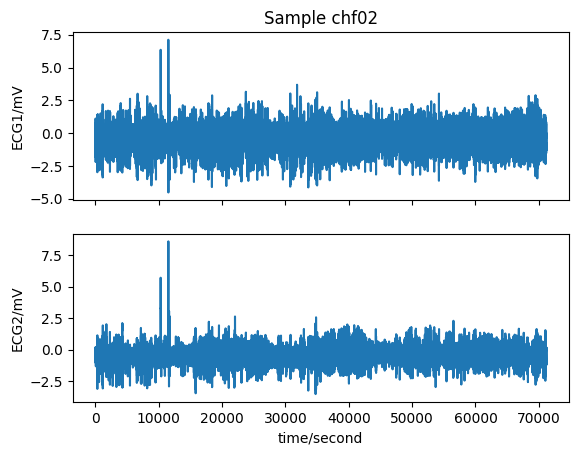

{'adc_gain': [200.0, 200.0],
 'adc_res': [12, 12],
 'adc_zero': [0, 0],
 'base_counter': None,
 'base_date': None,
 'base_time': datetime.time(13, 22),
 'baseline': [0, 0],
 'block_size': [0, 0],
 'byte_offset': [None, None],
 'checksum': [-250, -31980],
 'comments': ['Age: 61  Sex: F  NYHA class: III-IV'],
 'counter_freq': None,
 'd_signal': None,
 'e_d_signal': None,
 'e_p_signal': None,
 'file_name': ['chf02.dat', 'chf02.dat'],
 'fmt': ['212', '212'],
 'fs': 250,
 'init_value': [-97, -61],
 'n_sig': 2,
 'p_signal': array([[-0.485, -0.305],
       [-0.46 , -0.315],
       [-0.45 , -0.33 ],
       ...,
       [-0.76 , -0.185],
       [-0.78 , -0.16 ],
       [-0.76 , -0.18 ]]),
 'record_name': 'chf02',
 'samps_per_frame': [1, 1],
 'sig_len': 17793024,
 'sig_name': ['ECG1', 'ECG2'],
 'skew': [None, None],
 'units': ['mV', 'mV']}


In [4]:
CHFDB_DIR = "/content/drive/MyDrive/Projects/HRV/dataset/physionet.org/files/chfdb/1.0.0/"
record = wfdb.rdrecord(os.path.join(CHFDB_DIR, "chf02"))
wfdb.plot_wfdb(record=record, title="Sample chf02")
pprint.pprint(record.__dict__)

In [5]:
def slice_signal(record_obj, start_sec=0, end_sec=10, fs=250, _print=True):
    start = fs*start_sec
    end = fs*end_sec
    signal = record_obj.p_signal[start:end, 0]

    if _print:
        print("start        :", start)
        print("end          :", end)
        print("len(signal)  :", len(signal))
        print("seconds      :", end_sec - start_sec)

    detectors = ecgdetectors.Detectors(fs)
    r_peaks = detectors.two_average_detector(signal)
    if _print:
        print("len(r_peaks) :", len(r_peaks))
    return signal, r_peaks

def plot_signal(signal: np.array, r_peaks: list=None, figsize=(6, 4)):
    fig = plt.figure(figsize=figsize)
    plt.plot(signal)
    plt.gca().set_xlabel("")
    plt.gca().set_ylabel("mV")

    # ref: https://stackoverflow.com/questions/24988448/how-to-draw-vertical-lines-on-a-given-plot
    if r_peaks:
        for xc in r_peaks:
            plt.axvline(x=xc, color='red', linestyle='--')

    plt.show()

In [6]:
def rolling_slice(record_obj, start_sec=0, end_sec=20, size_sec=5, fs=250, _plot_signal=True, _print=True):
    full_r_peaks = []
    if end_sec == 'full':
        end_sec = len(record_obj.p_signal[:, 0]) // FS

    for _start_sec in range(start_sec, end_sec, size_sec):
        signal, r_peaks = slice_signal(record_obj, start_sec=_start_sec, end_sec=_start_sec+size_sec, fs=fs, _print=_print)
        r_peaks = list(np.array(r_peaks) + _start_sec*fs)
        full_r_peaks += r_peaks
        if _plot_signal:
            plot_signal(signal, r_peaks)
        if _print:
            print(r_peaks)
    if _print:
        print("len(full_r_peaks):", len(full_r_peaks))
    return full_r_peaks

In [ ]:
start_time = datetime.datetime.now()

chfdb = {}

START_SEC = 0
# END_SEC = 3600*18 # 18 jam
END_SEC = "full"
SIZE_SEC = 60 # 1 menit
FS = 250
_PLOT_SIGNAL = False
_PRINT = False
print("FS:", FS)
for record in wfdb.get_record_list("chfdb"):
    try:
        print("Record:", record)
        record_obj = wfdb.rdrecord(os.path.join(CHFDB_DIR, record))
        print("  signal length          :", record_obj.sig_len)
        print("  recording time (hours) :", record_obj.sig_len / (3600*FS))
        print("  comments               :", record_obj.comments)

        r_peaks = rolling_slice(
            record_obj,
            start_sec=START_SEC,
            end_sec=END_SEC,
            size_sec=SIZE_SEC,
            fs=FS,
            _plot_signal=_PLOT_SIGNAL,
            _print=_PRINT
        )
        # retrieve rr_interval from distance between 2 r_peak points
        rri = [r_peaks[i+1] - r_peaks[i] for i in range(len(r_peaks) - 1)]
        # convert the unit from freq_sample to milisecond
        rri = list(np.array(rri) * 1000 / FS)
        print("  len(r_peaks)           :", len(r_peaks))
        print("  len(rri)               :", len(rri))
        print("  recording time (secs)  :", record_obj.sig_len / FS)
        print("  r_peak / seconds       :", len(r_peaks) / (record_obj.sig_len / FS))

        RMSSD = hrv.HRV(FS).RMSSD(r_peaks)
        SDNN = hrv.HRV(FS).SDNN(r_peaks)
        print("  RMSSD                  :", RMSSD)
        print("  SDNN                   :", SDNN)

        nni = hrvanalysis.get_nn_intervals(rri)
        print("  len(nni)               :", len(nni))
        time_domain = hrvanalysis.extract_features.get_time_domain_features(nni)
        print("  time_domain Computed!")
        freq_domain = hrvanalysis.extract_features.get_frequency_domain_features(nni)
        print("  freq_domain Computed!")
        geom = hrvanalysis.extract_features.get_geometrical_features(nni)
        print("  geometrical features computed!")
        poincare = hrvanalysis.extract_features.get_poincare_plot_features(nni)
        print("  poincare features computed!")
        csi_cvi = hrvanalysis.extract_features.get_csi_cvi_features(nni)
        print("  csi cvi computed!")
        # Function computing the sample entropy of the given data.
        # Must use this function on short term recordings, from 1 minute window.
        if len(nni) <= 200:
            # Ref: https://ieeexplore.ieee.org/document/8295257
            # Sample entropy (SampEn), a popularly used “regularity analysis” tool,
            # has restrictions in handling shortterm segments (largely N ≤ 200) of
            # heart rate variability (HRV) data
            sampen = hrvanalysis.extract_features.get_sampen(nni)
            print("  sampen computed!")
        else:
            print("  nn > 200")
            print("  nn is set to NaN")
            sampen = {"sampen": np.nan}

        chfdb[record] = {
            "id": "chfdb-" + str(record),
            "db_source": "chfdb",
            "age": record_obj.comments[0].split()[1],
            "gender": record_obj.comments[0].split()[3],
            "fs": FS,
            "signal_length": record_obj.sig_len,
            "recording_time_hours": record_obj.sig_len / (3600 * FS),
            "recording_time_seconds": record_obj.sig_len // FS,
            "rri_length": len(rri),
            "nni_length": len(nni),
            **time_domain,
            **freq_domain,
            **geom,
            **poincare,
            **csi_cvi,
            **sampen,
            "cardiac_info": " ".join(record_obj.comments[0].split()[4:7]),
            "risk": 1,
        }
        print("  RECORD {} SAVED!".format(record))
    except:
        print("\n ERROR (%s)\n" %record)

print("Running time:", datetime.datetime.now() - start_time)

FS: 250
Record: chf01
  signal length          : 17994491
  recording time (hours) : 19.99387888888889
  comments               : ['Age: 71  Sex: M  NYHA class: III-IV']
  len(r_peaks)           : 75389
  len(rri)               : 75388
  recording time (secs)  : 71977.964
  r_peak / seconds       : 1.0473900039739938
  RMSSD                  : 199.48083092737252
  SDNN                   : 152.85367496698302
187 outlier(s) have been deleted.
The outlier(s) value(s) are : [2116.0, 2032.0, 2088.0, 220.0, 2024.0, 2036.0, 244.0, 2080.0, 2112.0, 2116.0, 2060.0, 2024.0, 2048.0, 2068.0, 2036.0, 2180.0, 2192.0, 2060.0, 2020.0, 2016.0, 2004.0, 2032.0, 2096.0, 2100.0, 2056.0, 2108.0, 2080.0, 2036.0, 2012.0, 2028.0, 2192.0, 2004.0, 2008.0, 2012.0, 2024.0, 2040.0, 2256.0, 2032.0, 2032.0, 2072.0, 2048.0, 2120.0, 2068.0, 2136.0, 2168.0, 2080.0, 2140.0, 2068.0, 2036.0, 2068.0, 2056.0, 2172.0, 2016.0, 2052.0, 2004.0, 2040.0, 2012.0, 2016.0, 2052.0, 2056.0, 2068.0, 2024.0, 2048.0, 2292.0, 2060.0, 2040.0

In [ ]:
pprint.pprint(chfdb[list(chfdb.keys())[0]])

{'Modified_csi': 1528.3622072668436,
 'age': '71',
 'cardiac_info': 'NYHA class: III-IV',
 'csi': 2.423417134537219,
 'cvi': 5.215168057570386,
 'cvnni': 0.12701790322304524,
 'cvsd': 0.09689925614950617,
 'db_source': 'chfdb',
 'fs': 250,
 'gender': 'M',
 'hf': 1952.4112596653065,
 'hfnu': 39.488045325323256,
 'id': 'chfdb-chf01',
 'lf': 2991.898451236606,
 'lf_hf_ratio': 1.5324120040925673,
 'lfnu': 60.51195467467674,
 'max_hr': 197.3684210526316,
 'mean_hr': 64.36252062428454,
 'mean_nni': 949.5145513874887,
 'median_nni': 948.0,
 'min_hr': 30.0,
 'nni_20': 29621,
 'nni_50': 22872,
 'nni_length': 75388,
 'pnni_20': 39.29192035762134,
 'pnni_50': 30.339448446018544,
 'range_nni': 1696.0,
 'ratio_sd2_sd1': 2.423417134537219,
 'recording_time_hours': 19.99387888888889,
 'recording_time_seconds': 71977,
 'risk': 1,
 'rmssd': 92.00725373257971,
 'rri_length': 75388,
 'sampen': nan,
 'sd1': 65.05938451079084,
 'sd2': 157.66602718589584,
 'sdnn': 120.60534739700925,
 'sdsd': 92.00725369584

In [ ]:
df_chfdb = pd.DataFrame(chfdb).T
df_chfdb

,id,db_source,age,gender,fs,signal_length,recording_time_hours,recording_time_seconds,rri_length,nni_length,...,tinn,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk
chf01,chfdb-chf01,chfdb,71,M,250,17994491,19.993879,71977,75388,75388,...,None,65.059385,157.666027,2.423417,2.423417,5.215168,1528.362207,NaN,NYHA class: III-IV,1
chf02,chfdb-chf02,chfdb,61,F,250,17793024,19.770027,71172,114002,114002,...,None,63.475802,169.174463,2.66518,2.66518,5.235063,1803.521863,NaN,NYHA class: III-IV,1
chf03,chfdb-chf03,chfdb,63,M,250,17998848,19.99872,71995,81081,81081,...,None,59.634466,130.4097,2.186818,2.186818,5.094927,1140.728905,NaN,NYHA class: III-IV,1
chf04,chfdb-chf04,chfdb,54,M,250,17998848,19.99872,71995,111815,111815,...,None,27.005612,78.45251,2.905045,2.905045,4.530181,911.632205,NaN,NYHA class: III-IV,1
chf05,chfdb-chf05,chfdb,59,F,250,17802240,19.780267,71208,118561,118561,...,None,11.591391,72.759983,6.277071,6.277071,4.130148,1826.878277,NaN,NYHA class: III-IV,1
chf06,chfdb-chf06,chfdb,?,M,250,17789952,19.766613,71159,117835,117835,...,None,53.361941,112.926598,2.116239,2.116239,4.984148,955.918495,NaN,NYHA class: III-IV,1
chf07,chfdb-chf07,chfdb,48,M,250,17998848,19.99872,71995,92188,92188,...,None,35.891803,112.771104,3.141974,3.141974,4.811313,1417.295393,NaN,NYHA class: III-IV,1
chf08,chfdb-chf08,chfdb,51,M,250,17998848,19.99872,71995,90496,90496,...,None,44.876487,104.347399,2.325213,2.325213,4.87462,970.519773,NaN,NYHA class: III-IV,1
chf09,chfdb-chf09,chfdb,63,F,250,17796577,19.773974,71186,114441,114441,...,None,15.96162,52.953167,3.317531,3.317531,4.131089,702.695062,NaN,NYHA class: III-IV,1
chf10,chfdb-chf10,chfdb,22,M,250,17995711,19.995234,71982,147240,147240,...,None,6.188796,30.187682,4.877795,4.877795,3.475556,588.997334,NaN,NYHA class: III-IV,1


In [ ]:
df_chfdb.to_csv("df_chfdb_two_average.csv", index=False)
df_chfdb.to_excel("df_chfdb_two_average.xlsx", index=False)

In [ ]:
pd.read_csv("df_chfdb_two_average.csv")

,id,db_source,age,gender,fs,signal_length,recording_time_hours,recording_time_seconds,rri_length,nni_length,...,tinn,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk
0,chfdb-chf01,chfdb,71,M,250,17994491,19.993879,71977,75388,75388,...,NaN,65.059385,157.666027,2.423417,2.423417,5.215168,1528.362207,NaN,NYHA class: III-IV,1
1,chfdb-chf02,chfdb,61,F,250,17793024,19.770027,71172,114002,114002,...,NaN,63.475802,169.174463,2.665180,2.665180,5.235063,1803.521863,NaN,NYHA class: III-IV,1
2,chfdb-chf03,chfdb,63,M,250,17998848,19.998720,71995,81081,81081,...,NaN,59.634466,130.409700,2.186818,2.186818,5.094927,1140.728905,NaN,NYHA class: III-IV,1
3,chfdb-chf04,chfdb,54,M,250,17998848,19.998720,71995,111815,111815,...,NaN,27.005612,78.452510,2.905045,2.905045,4.530181,911.632205,NaN,NYHA class: III-IV,1
4,chfdb-chf05,chfdb,59,F,250,17802240,19.780267,71208,118561,118561,...,NaN,11.591391,72.759983,6.277071,6.277071,4.130148,1826.878277,NaN,NYHA class: III-IV,1
5,chfdb-chf06,chfdb,?,M,250,17789952,19.766613,71159,117835,117835,...,NaN,53.361941,112.926598,2.116239,2.116239,4.984148,955.918495,NaN,NYHA class: III-IV,1
6,chfdb-chf07,chfdb,48,M,250,17998848,19.998720,71995,92188,92188,...,NaN,35.891803,112.771104,3.141974,3.141974,4.811313,1417.295393,NaN,NYHA class: III-IV,1
7,chfdb-chf08,chfdb,51,M,250,17998848,19.998720,71995,90496,90496,...,NaN,44.876487,104.347399,2.325213,2.325213,4.874620,970.519773,NaN,NYHA class: III-IV,1
8,chfdb-chf09,chfdb,63,F,250,17796577,19.773974,71186,114441,114441,...,NaN,15.961620,52.953167,3.317531,3.317531,4.131089,702.695062,NaN,NYHA class: III-IV,1
9,chfdb-chf10,chfdb,22,M,250,17995711,19.995234,71982,147240,147240,...,NaN,6.188796,30.187682,4.877795,4.877795,3.475556,588.997334,NaN,NYHA class: III-IV,1


In [ ]:
pd.read_excel("df_chfdb_two_average.xlsx")

,id,db_source,age,gender,fs,signal_length,recording_time_hours,recording_time_seconds,rri_length,nni_length,...,tinn,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk
0,chfdb-chf01,chfdb,71,M,250,17994491,19.993879,71977,75388,75388,...,NaN,65.059385,157.666027,2.423417,2.423417,5.215168,1528.362207,NaN,NYHA class: III-IV,1
1,chfdb-chf02,chfdb,61,F,250,17793024,19.770027,71172,114002,114002,...,NaN,63.475802,169.174463,2.665180,2.665180,5.235063,1803.521863,NaN,NYHA class: III-IV,1
2,chfdb-chf03,chfdb,63,M,250,17998848,19.998720,71995,81081,81081,...,NaN,59.634466,130.409700,2.186818,2.186818,5.094927,1140.728905,NaN,NYHA class: III-IV,1
3,chfdb-chf04,chfdb,54,M,250,17998848,19.998720,71995,111815,111815,...,NaN,27.005612,78.452510,2.905045,2.905045,4.530181,911.632205,NaN,NYHA class: III-IV,1
4,chfdb-chf05,chfdb,59,F,250,17802240,19.780267,71208,118561,118561,...,NaN,11.591391,72.759983,6.277071,6.277071,4.130148,1826.878277,NaN,NYHA class: III-IV,1
5,chfdb-chf06,chfdb,?,M,250,17789952,19.766613,71159,117835,117835,...,NaN,53.361941,112.926598,2.116239,2.116239,4.984148,955.918495,NaN,NYHA class: III-IV,1
6,chfdb-chf07,chfdb,48,M,250,17998848,19.998720,71995,92188,92188,...,NaN,35.891803,112.771104,3.141974,3.141974,4.811313,1417.295393,NaN,NYHA class: III-IV,1
7,chfdb-chf08,chfdb,51,M,250,17998848,19.998720,71995,90496,90496,...,NaN,44.876487,104.347399,2.325213,2.325213,4.874620,970.519773,NaN,NYHA class: III-IV,1
8,chfdb-chf09,chfdb,63,F,250,17796577,19.773974,71186,114441,114441,...,NaN,15.961620,52.953167,3.317531,3.317531,4.131089,702.695062,NaN,NYHA class: III-IV,1
9,chfdb-chf10,chfdb,22,M,250,17995711,19.995234,71982,147240,147240,...,NaN,6.188796,30.187682,4.877795,4.877795,3.475556,588.997334,NaN,NYHA class: III-IV,1


## Uses Defined Annotation

In [7]:
record = "chf01"
ann = wfdb.rdann(os.path.join(CHFDB_DIR, record), extension='ecg')
record_hea = wfdb.rdheader(os.path.join(CHFDB_DIR, record))
record_obj = wfdb.rdrecord(os.path.join(CHFDB_DIR, record))

r_peaks = np.array(ann.sample, dtype=np.float32)
annotation = np.array(ann.symbol)

In [13]:
from google.colab import output

DATABASE = "chfdb"

start_time = datetime.datetime.now()

FS = 250

chfdb = {}
errs = []
for record in wfdb.get_record_list(DATABASE):
    print("Record:", record)
    ann = wfdb.rdann(os.path.join(CHFDB_DIR, record), extension='ecg')
    record_hea = wfdb.rdheader(os.path.join(CHFDB_DIR, record))
    record_obj = wfdb.rdrecord(os.path.join(CHFDB_DIR, record))

    r_peaks = np.array(ann.sample, dtype=np.float32)
    annotation = np.array(ann.symbol)

    # counting ectopic beats
    abnormal_beat_num = 0
    for _sym, _count in np.transpose(np.unique(annotation, return_counts=True)):
        if _sym != 'N':
            abnormal_beat_num += int(_count)
        if _sym == 'N':
            normal_beat_num = int(_count)
    normal_beats_ratio = normal_beat_num / (normal_beat_num + abnormal_beat_num)

    # check & replace ectopic beat with np.nan
    for idx, ann in enumerate(annotation):
        if str(ann).upper() != 'N':
            r_peaks[idx] = np.nan
    # interpolate
    r_peaks = hrvanalysis.preprocessing.interpolate_nan_values(r_peaks)

    # retrieve rr_interval from distance between 2 r_peak points
    rri = [r_peaks[i+1] - r_peaks[i] for i in range(len(r_peaks) - 1)]
    # convert the unit from freq_sample to milisecond
    rri = list(np.array(rri) * 1000 / FS)
    print("  len(r_peaks)           :", len(r_peaks))
    print("  len(rri)               :", len(rri))

    id = "{0}-{1}".format(DATABASE, record)
    try:
        rri = hrvanalysis.preprocessing.remove_outliers(
            rri,
            low_rri = 300,
            high_rri = 2000,
        )
        nni = hrvanalysis.preprocessing.interpolate_nan_values(rri)

        # remove nan values if exists
        nni = [val for val in nni if np.isfinite(val)]
        print("  len(nni)               :", len(nni))
        time_domain = hrvanalysis.extract_features.get_time_domain_features(nni)
        print("  time_domain computed!")
        freq_domain = hrvanalysis.extract_features.get_frequency_domain_features(nni)
        print("  freq_domain computed!")
        geom = hrvanalysis.extract_features.get_geometrical_features(nni)
        print("  geometrical features computed!")
        poincare = hrvanalysis.extract_features.get_poincare_plot_features(nni)
        print("  poincare features computed!")
        csi_cvi = hrvanalysis.extract_features.get_csi_cvi_features(nni)
        print("  csi cvi computed!")
        # Function computing the sample entropy of the given data.
        # Must use this function on short term recordings, from 1 minute window.
        if len(nni) <= 200:
            # Ref: https://ieeexplore.ieee.org/document/8295257
            # Sample entropy (SampEn), a popularly used “regularity analysis” tool,
            # has restrictions in handling shortterm segments (largely N ≤ 200) of
            # heart rate variability (HRV) data
            sampen = hrvanalysis.extract_features.get_sampen(nni)
            print("  sampen computed!")
        else:
            print("  nn > 200")
            print("  nn is set to NaN")
            sampen = {"sampen": np.nan}

        chfdb[id] = {
            "id": id,
            "db_source": DATABASE,
            "age": record_hea.comments[0].split()[1],
            "gender": record_hea.comments[0].split()[3],
            "fs": FS,
            "signal_length": record_obj.sig_len,
            "recording_time_hours": record_obj.sig_len / (3600 * FS),
            "recording_time_seconds": record_obj.sig_len // FS,
            "normal_beats": normal_beat_num,
            "abnormal_beats": abnormal_beat_num,
            "normal_beats_ratio": normal_beats_ratio,
            "rri_length": len(rri),
            "nni_length": len(nni),
            **time_domain,
            **freq_domain,
            **geom,
            **poincare,
            **csi_cvi,
            **sampen,
            "cardiac_info": " ".join(record_obj.comments[0].split()[4:7]),
            "risk": 1,
        }
        print("  RECORD {} SAVED!\n".format(id))
    except:
        print("  \nERROR at {}\n".format(id))
        errs.append(id)
    finally:
        output.clear()

print("\n"+"="*50)
print(datetime.datetime.now() - start_time)
print("error nums   :", len(errs))


0:01:22.213958
error nums   : 0


In [14]:
df_chfdb = pd.DataFrame(chfdb).T
df_chfdb

,id,db_source,age,gender,fs,signal_length,recording_time_hours,recording_time_seconds,normal_beats,abnormal_beats,normal_beats_ratio,rri_length,nni_length,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf,triangular_index,tinn,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk
chfdb-chf01,chfdb-chf01,chfdb,71,M,250,17994491,19.993879,71977,74985,563,0.992548,75547,75547,952.705548,84.527114,33.45094,2226,2.946549,14437,19.110211,33.45094,948.0,1588.0,0.035112,0.088723,63.489946,151.515152,30.241935,5.842346,261.902827,209.107569,1.252479,55.604468,44.395532,720.576116,249.565721,19.922732,None,23.653543,117.175834,4.953839,4.953839,4.646854,2321.880651,NaN,NYHA class: III-IV,1
chfdb-chf02,chfdb-chf02,chfdb,61,F,250,17793024,19.770027,71172,91031,23517,0.794697,114547,114547,601.166377,39.069432,29.87269,1911,1.668325,5431,4.741327,29.87269,596.0,1464.0,0.049691,0.064989,100.182119,194.805195,33.860045,6.035457,227.859204,158.081697,1.441402,59.039921,40.960079,743.993411,358.05251,9.016609,None,21.123274,51.055346,2.417019,2.417019,4.236922,493.606884,NaN,NYHA class: III-IV,1
chfdb-chf03,chfdb-chf03,chfdb,63,M,250,17998848,19.99872,71995,78722,2579,0.968278,81300,81300,885.356232,72.132474,43.478327,3908,4.806947,7767,9.553623,43.478327,900.0,1544.0,0.049108,0.081473,68.365623,200.0,32.537961,7.674556,463.303481,468.208253,0.989524,49.73673,50.26327,1302.399882,370.888148,11.846131,None,30.744009,97.267639,3.163792,3.163792,4.679849,1230.938163,NaN,NYHA class: III-IV,1
chfdb-chf04,chfdb-chf04,chfdb,54,M,250,17998848,19.99872,71995,110774,1592,0.985832,112365,112365,640.765915,52.66487,31.371502,7263,6.463814,14077,12.528034,31.371502,640.0,944.0,0.048959,0.08219,94.279137,200.0,48.231511,7.886676,40.968869,42.937864,0.954143,48.826676,51.173324,232.059491,148.152759,16.036107,None,22.183101,71.099136,3.205104,3.205104,4.402007,911.520405,NaN,NYHA class: III-IV,1
chfdb-chf05,chfdb-chf05,chfdb,59,F,250,17802240,19.780267,71208,118463,690,0.994209,119152,119152,597.628374,50.859739,13.910659,286,0.240032,3391,2.845969,13.910659,600.0,1376.0,0.023276,0.085103,101.132294,140.186916,33.259424,8.707188,40.860727,31.285602,1.306055,56.635906,43.364094,180.479528,108.333199,17.662615,None,9.836362,71.250768,7.24361,7.24361,4.049744,2064.450992,NaN,NYHA class: III-IV,1
chfdb-chf06,chfdb-chf06,chfdb,?,M,250,17789952,19.766613,71159,111894,6740,0.943187,118633,118633,600.063524,88.716769,114.078187,52418,44.18538,63230,53.299278,114.078187,608.0,944.0,0.19011,0.147846,102.346025,200.0,48.231511,16.325413,278.6494,1095.22454,0.254422,20.282021,79.717979,1529.119798,155.245858,22.211758,None,80.665799,96.095572,1.19128,1.19128,5.093513,457.907016,NaN,NYHA class: III-IV,1
chfdb-chf07,chfdb-chf07,chfdb,48,M,250,17998848,19.99872,71995,90503,2081,0.977523,92583,92583,777.634166,58.879106,16.647295,447,0.482815,9343,10.091594,16.647295,772.0,734.0,0.021408,0.075716,77.60854,196.078431,57.692308,6.0596,42.403972,38.93498,1.089097,52.13243,47.86757,151.45979,70.120839,14.937561,None,11.771479,82.431368,7.002635,7.002635,4.191044,2308.947092,NaN,NYHA class: III-IV,1
chfdb-chf08,chfdb-chf08,chfdb,51,M,250,17998848,19.99872,71995,89577,1182,0.986976,90758,90758,793.25882,61.062065,17.000924,446,0.491422,5845,6.440275,17.000924,792.0,1126.0,0.021432,0.076976,76.104494,181.818182,41.208791,6.209545,146.137526,76.779337,1.903344,65.556963,34.443037,498.920038,276.003175,17.876305,None,12.021535,85.513942,7.113396,7.113396,4.216117,2433.178288,NaN,NYHA class: III-IV,1
chfdb-chf09,chfdb-chf09,chfdb,63,F,250,17796577,19.773974,71186,114096,956,0.991691,115051,115051,618.712693,35.016596,15.354402,821,0.713603,5387,4.682312,15.354402,608.0,1016.0,0.024817,0.056596,97.283645,200.0,45.592705,5.527157,31.976958,44.809349,0.713622,41.644089,58.355911,101.578337,24.792031,7.011457,None,10.857249,48.316086,4.450122,4.450122,3.923932,860.

In [15]:
df_chfdb.to_csv("df_chfdb.csv", index=False)
df_chfdb.to_excel("df_chfdb.xlsx", index=False)

In [16]:
pd.set_option("display.max_columns", None)

In [18]:
pd.read_csv("df_chfdb.csv")

,id,db_source,age,gender,fs,signal_length,recording_time_hours,recording_time_seconds,normal_beats,abnormal_beats,normal_beats_ratio,rri_length,nni_length,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf,triangular_index,tinn,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk
0,chfdb-chf01,chfdb,71,M,250,17994491,19.993879,71977,74985,563,0.992548,75547,75547,952.705548,84.527114,33.450940,2226,2.946549,14437,19.110211,33.450940,948.0,1588.0,0.035112,0.088723,63.489946,151.515152,30.241935,5.842346,261.902827,209.107569,1.252479,55.604468,44.395532,720.576116,249.565721,19.922732,NaN,23.653543,117.175834,4.953839,4.953839,4.646854,2321.880651,NaN,NYHA class: III-IV,1
1,chfdb-chf02,chfdb,61,F,250,17793024,19.770027,71172,91031,23517,0.794697,114547,114547,601.166377,39.069432,29.872690,1911,1.668325,5431,4.741327,29.872690,596.0,1464.0,0.049691,0.064989,100.182119,194.805195,33.860045,6.035457,227.859204,158.081697,1.441402,59.039921,40.960079,743.993411,358.052510,9.016609,NaN,21.123274,51.055346,2.417019,2.417019,4.236922,493.606884,NaN,NYHA class: III-IV,1
2,chfdb-chf03,chfdb,63,M,250,17998848,19.998720,71995,78722,2579,0.968278,81300,81300,885.356232,72.132474,43.478327,3908,4.806947,7767,9.553623,43.478327,900.0,1544.0,0.049108,0.081473,68.365623,200.000000,32.537961,7.674556,463.303481,468.208253,0.989524,49.736730,50.263270,1302.399882,370.888148,11.846131,NaN,30.744009,97.267639,3.163792,3.163792,4.679849,1230.938163,NaN,NYHA class: III-IV,1
3,chfdb-chf04,chfdb,54,M,250,17998848,19.998720,71995,110774,1592,0.985832,112365,112365,640.765915,52.664870,31.371502,7263,6.463814,14077,12.528034,31.371502,640.0,944.0,0.048959,0.082190,94.279137,200.000000,48.231511,7.886676,40.968869,42.937864,0.954143,48.826676,51.173324,232.059491,148.152759,16.036107,NaN,22.183101,71.099136,3.205104,3.205104,4.402007,911.520405,NaN,NYHA class: III-IV,1
4,chfdb-chf05,chfdb,59,F,250,17802240,19.780267,71208,118463,690,0.994209,119152,119152,597.628374,50.859739,13.910659,286,0.240032,3391,2.845969,13.910659,600.0,1376.0,0.023276,0.085103,101.132294,140.186916,33.259424,8.707188,40.860727,31.285602,1.306055,56.635906,43.364094,180.479528,108.333199,17.662615,NaN,9.836362,71.250768,7.243610,7.243610,4.049744,2064.450992,NaN,NYHA class: III-IV,1
5,chfdb-chf06,chfdb,?,M,250,17789952,19.766613,71159,111894,6740,0.943187,118633,118633,600.063524,88.716769,114.078187,52418,44.185380,63230,53.299278,114.078187,608.0,944.0,0.190110,0.147846,102.346025,200.000000,48.231511,16.325413,278.649400,1095.224540,0.254422,20.282021,79.717979,1529.119798,155.245858,22.211758,NaN,80.665799,96.095572,1.191280,1.191280,5.093513,457.907016,NaN,NYHA class: III-IV,1
6,chfdb-chf07,chfdb,48,M,250,17998848,19.998720,71995,90503,2081,0.977523,92583,92583,777.634166,58.879106,16.647295,447,0.482815,9343,10.091594,16.647295,772.0,734.0,0.021408,0.075716,77.608540,196.078431,57.692308,6.059600,42.403972,38.934980,1.089097,52.132430,47.867570,151.459790,70.120839,14.937561,NaN,11.771479,82.431368,7.002635,7.002635,4.191044,2308.947092,NaN,NYHA class: III-IV,1
7,chfdb-chf08,chfdb,51,M,250,17998848,19.998720,71995,89577,1182,0.986976,90758,90758,793.258820,61.062065,17.000924,446,0.491422,5845,6.440275,17.000924,792.0,1126.0,0.021432,0.076976,76.104494,181.818182,41.208791,6.209545,146.137526,76.779337,1.903344,65.556963,34.443037,498.920038,276.003175,17.876305,NaN,12.021535,85.513942,7.113396,7.113396,4.216117,2433.178288,NaN,NYHA class: III-IV,1
8,chfdb-chf09,chfdb,63,F,250,17796577,19.773974,71186,114096,956,0.991691,115051,115051,618.712693,35.016596,15.354402,821,0.713603,5387,4.682312,15.354402,608.0,1016.0,0.024817,0.056596,97.283645,200.000000,45.592705,5.527157,31.976958,44.809349,0.713622,41.644089,58.355911,101.578337,24.792031,7.011457,NaN,10.857249,48.316086,4.450122,4.450122,3.923932,860.049978,NaN,NYHA class: III-IV,1
9,chfdb-chf10,chf

In [19]:
pd.read_excel("df_chfdb.xlsx")

,id,db_source,age,gender,fs,signal_length,recording_time_hours,recording_time_seconds,normal_beats,abnormal_beats,normal_beats_ratio,rri_length,nni_length,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf,triangular_index,tinn,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk
0,chfdb-chf01,chfdb,71,M,250,17994491,19.993879,71977,74985,563,0.992548,75547,75547,952.705548,84.527114,33.450940,2226,2.946549,14437,19.110211,33.450940,948,1588,0.035112,0.088723,63.489946,151.515152,30.241935,5.842346,261.902827,209.107569,1.252479,55.604468,44.395532,720.576116,249.565721,19.922732,NaN,23.653543,117.175834,4.953839,4.953839,4.646854,2321.880651,NaN,NYHA class: III-IV,1
1,chfdb-chf02,chfdb,61,F,250,17793024,19.770027,71172,91031,23517,0.794697,114547,114547,601.166377,39.069432,29.872690,1911,1.668325,5431,4.741327,29.872690,596,1464,0.049691,0.064989,100.182119,194.805195,33.860045,6.035457,227.859204,158.081697,1.441402,59.039921,40.960079,743.993411,358.052510,9.016609,NaN,21.123274,51.055346,2.417019,2.417019,4.236922,493.606884,NaN,NYHA class: III-IV,1
2,chfdb-chf03,chfdb,63,M,250,17998848,19.998720,71995,78722,2579,0.968278,81300,81300,885.356232,72.132474,43.478327,3908,4.806947,7767,9.553623,43.478327,900,1544,0.049108,0.081473,68.365623,200.000000,32.537961,7.674556,463.303481,468.208253,0.989524,49.736730,50.263270,1302.399882,370.888148,11.846131,NaN,30.744009,97.267639,3.163792,3.163792,4.679849,1230.938163,NaN,NYHA class: III-IV,1
3,chfdb-chf04,chfdb,54,M,250,17998848,19.998720,71995,110774,1592,0.985832,112365,112365,640.765915,52.664870,31.371502,7263,6.463814,14077,12.528034,31.371502,640,944,0.048959,0.082190,94.279137,200.000000,48.231511,7.886676,40.968869,42.937864,0.954143,48.826676,51.173324,232.059491,148.152759,16.036107,NaN,22.183101,71.099136,3.205104,3.205104,4.402007,911.520405,NaN,NYHA class: III-IV,1
4,chfdb-chf05,chfdb,59,F,250,17802240,19.780267,71208,118463,690,0.994209,119152,119152,597.628374,50.859739,13.910659,286,0.240032,3391,2.845969,13.910659,600,1376,0.023276,0.085103,101.132294,140.186916,33.259424,8.707188,40.860727,31.285602,1.306055,56.635906,43.364094,180.479528,108.333199,17.662615,NaN,9.836362,71.250768,7.243610,7.243610,4.049744,2064.450992,NaN,NYHA class: III-IV,1
5,chfdb-chf06,chfdb,?,M,250,17789952,19.766613,71159,111894,6740,0.943187,118633,118633,600.063524,88.716769,114.078187,52418,44.185380,63230,53.299278,114.078187,608,944,0.190110,0.147846,102.346025,200.000000,48.231511,16.325413,278.649400,1095.224540,0.254422,20.282021,79.717979,1529.119798,155.245858,22.211758,NaN,80.665799,96.095572,1.191280,1.191280,5.093513,457.907016,NaN,NYHA class: III-IV,1
6,chfdb-chf07,chfdb,48,M,250,17998848,19.998720,71995,90503,2081,0.977523,92583,92583,777.634166,58.879106,16.647295,447,0.482815,9343,10.091594,16.647295,772,734,0.021408,0.075716,77.608540,196.078431,57.692308,6.059600,42.403972,38.934980,1.089097,52.132430,47.867570,151.459790,70.120839,14.937561,NaN,11.771479,82.431368,7.002635,7.002635,4.191044,2308.947092,NaN,NYHA class: III-IV,1
7,chfdb-chf08,chfdb,51,M,250,17998848,19.998720,71995,89577,1182,0.986976,90758,90758,793.258820,61.062065,17.000924,446,0.491422,5845,6.440275,17.000924,792,1126,0.021432,0.076976,76.104494,181.818182,41.208791,6.209545,146.137526,76.779337,1.903344,65.556963,34.443037,498.920038,276.003175,17.876305,NaN,12.021535,85.513942,7.113396,7.113396,4.216117,2433.178288,NaN,NYHA class: III-IV,1
8,chfdb-chf09,chfdb,63,F,250,17796577,19.773974,71186,114096,956,0.991691,115051,115051,618.712693,35.016596,15.354402,821,0.713603,5387,4.682312,15.354402,608,1016,0.024817,0.056596,97.283645,200.000000,45.592705,5.527157,31.976958,44.809349,0.713622,41.644089,58.355911,101.578337,24.792031,7.011457,NaN,10.857249,48.316086,4.450122,4.450122,3.923932,860.049978,NaN,NYHA class: III-IV,1
9,chfdb-chf10,chfdb,22,M,250,17995711,19.995234,71982